In [5]:
import torchvision
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
import copy
import os
import torch
from tqdm.autonotebook import tqdm
from torch.optim.lr_scheduler import _LRScheduler
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset

/home/sanjaymoto75/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [6]:
import pandas as pd
train_label = pd.read_csv('./TrainLabels.csv')
valid_label = pd.read_csv('./DAiSEE/Labels/ValidationLabels.csv')
valid_label.head(10)

,ClipID,Boredom,Engagement,Confusion,Frustration
0,4000221001.avi,0,2,0,0
1,4000221002.avi,1,3,0,0
2,4000221006.avi,1,2,0,0
3,4000221008.avi,0,3,0,0
4,4000221009.avi,2,2,0,0
5,4000221010.avi,2,2,1,1
6,4000221011.avi,2,2,1,0
7,4000221013.avi,3,2,0,0
8,4000221014.avi,2,2,0,1
9,4000221015.avi,3,2,3,0


In [7]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
from tqdm.autonotebook import tqdm
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import sys
im_size = 224
train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor()])

In [8]:
class video_dataset(Dataset):
    def __init__(self,frame_dir,train_csv,sequencelength = 60,transform = None):
        self.folder = os.listdir(frame_dir)
        self.id = train_csv['ClipID']
        self.engagement = train_csv['Engagement']
        self.frame_dir = frame_dir
        self.transform = transform
        self.sequence_length = sequence_length
        self.skip_length = int(300/sequence_length)
    def __len__(self):
        return len(self.id)
    def __getitem__(self,idx):
        id_1 = self.id[idx][:6]
        path1 = os.path.join(self.frame_dir,id_1)
        id_2 = self.id[idx][:-4]
        path2 = os.path.join(path1,id_2)
        seq_image = list()
        i = 0
        while i<300:
            path3 = os.path.join(path2,str(i)+'.jpg')
            image = cv2.imread(path3)
            if(self.transform):
                image = self.transform(image)
            seq_image.append(image)
            i = i+self.skip_length
        seq_image = torch.stack(seq_image)
        label = self.engagement[idx]
        seq_image = seq_image.reshape(3,self.sequence_length,im_size,im_size)
        return seq_image,label

In [9]:
mean = [0.4889, 0.4887, 0.4891]

In [10]:
std = [0.2074, 0.2074, 0.2074]

In [11]:
train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        #transforms.RandomRotation(degrees=10),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
train_data = video_dataset('./frames/train',train_label,transform = train_transforms)
val_data = video_dataset('./frames/val',valid_label,transform = test_transforms)
train_loader = DataLoader(train_data,batch_size = 4,num_workers = 4 ,shuffle = True)
valid_loader = DataLoader(val_data,batch_size = 4,num_workers = 4 ,shuffle = True)
dataloaders = {'train':train_loader,'val':valid_loader}

NameError: name 'sequence_length' is not defined

In [65]:
#Model t3d
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

__all__ = ['DenseNet', 'densenet121', 'densenet161'] # with DropOut

class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm3d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv3d(num_input_features, bn_size *
                        growth_rate, kernel_size=1, stride=1, bias=False)),
        self.add_module('norm2', nn.BatchNorm3d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv3d(bn_size * growth_rate, growth_rate,
                        kernel_size=3, stride=1, padding=1, bias=False)),
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)


class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm3d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv3d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool3d(kernel_size=2, stride=2))


class DenseNet3D(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
    """
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000):

        super(DenseNet3D, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv3d(3, num_init_features, kernel_size=(3, 7, 7), stride=2, padding=(1, 3, 3), bias=False)),
            ('norm0', nn.BatchNorm3d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool3d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm3d(num_features))
        # Linear layer
    def forward(self, x):
        features = self.features(x)
        return features
    

def densenet121_3D():
    model = DenseNet3D(num_init_features=64, growth_rate=32, block_config=(6, 12, 24, 16))
    return model


def densenet121_3D_DropOut(pretrain = False):
    model = DenseNet3D(num_init_features=64, growth_rate=32, block_config=(6, 12, 24, 16), drop_rate=0.2)
    if(pretrain):
        model.load_state_dict(torch.load('./t3dpre5.h5'))
    return model


def densenet169_3D():
    model = DenseNet3D(num_init_features=64, growth_rate=32, block_config=(6, 12, 32, 32))
    return model


# the below model has the lowest Top-1 error in ImageNet Data Set:
def densenet161_3D():
    model = DenseNet3D(num_init_features=96, growth_rate=48, block_config=(6, 12, 36, 24))
    return model


# the below model has the lowest Top-1 error in ImageNet Data Set:
def densenet161_3D_DropOut():
    model = DenseNet3D(num_init_features=96, growth_rate=48, block_config=(6, 12, 36, 24), drop_rate=0.2)
    return model


def densenet201_3D():
    model = DenseNet3D(num_init_features=64, growth_rate=32, block_config=(6, 12, 48, 32))
    return model


def densenet121(**kwargs):
    """Constructs a DenseNet-121_DropOut model.
    """
    model = DenseNet3D(num_init_features=64, growth_rate=32, block_config=(6, 12, 24, 16), drop_rate=0.2, **kwargs)
    return model


def densenet161(**kwargs):
    """Constructs a DenseNet-161_DropOut model.
    """
    model = DenseNet3D(num_init_features=96, growth_rate=48, block_config=(6, 12, 36, 24), drop_rate=0.2, **kwargs)
    return model

In [63]:
class classifier(nn.Module):
    def __init__(self):
        super(classifier, self).__init__()
        self.t3d = densenet121_3D_DropOut(True)
        self.linear = nn.Linear(2048, 512)
        self.elu = nn.ELU()
        self.out = nn.Linear(512, 4)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
    def forward(self, seq):
        features = self.t3d(seq)
        out = F.relu(features, inplace=True)
        avg_pool = nn.functional.adaptive_avg_pool3d(out, output_size = 1)
        max_pool = nn.functional.adaptive_max_pool3d(out, output_size = 1)
        out = torch.cat((avg_pool,max_pool),1)
        batch = out.shape[0]
        out = out.view(batch, -1)
        conc = self.elu(self.linear(self.dropout1(out)))
        res = self.out(self.dropout2(conc))
        return res

In [66]:
model = classifier().to('cuda')

AttributeError: 'collections.OrderedDict' object has no attribute 'module'

In [14]:
model = model.to('cuda')
model = nn.DataParallel(model)

In [16]:
model.load_state_dict(torch.load('t3dpre.h5'))

RuntimeError: Error(s) in loading state_dict for DataParallel:
	Missing key(s) in state_dict: "module.features.conv0.weight", "module.features.norm0.weight", "module.features.norm0.bias", "module.features.norm0.running_mean", "module.features.norm0.running_var", "module.features.denseblock1.denselayer1.norm1.weight", "module.features.denseblock1.denselayer1.norm1.bias", "module.features.denseblock1.denselayer1.norm1.running_mean", "module.features.denseblock1.denselayer1.norm1.running_var", "module.features.denseblock1.denselayer1.conv1.weight", "module.features.denseblock1.denselayer1.norm2.weight", "module.features.denseblock1.denselayer1.norm2.bias", "module.features.denseblock1.denselayer1.norm2.running_mean", "module.features.denseblock1.denselayer1.norm2.running_var", "module.features.denseblock1.denselayer1.conv2.weight", "module.features.denseblock1.denselayer2.norm1.weight", "module.features.denseblock1.denselayer2.norm1.bias", "module.features.denseblock1.denselayer2.norm1.running_mean", "module.features.denseblock1.denselayer2.norm1.running_var", "module.features.denseblock1.denselayer2.conv1.weight", "module.features.denseblock1.denselayer2.norm2.weight", "module.features.denseblock1.denselayer2.norm2.bias", "module.features.denseblock1.denselayer2.norm2.running_mean", "module.features.denseblock1.denselayer2.norm2.running_var", "module.features.denseblock1.denselayer2.conv2.weight", "module.features.denseblock1.denselayer3.norm1.weight", "module.features.denseblock1.denselayer3.norm1.bias", "module.features.denseblock1.denselayer3.norm1.running_mean", "module.features.denseblock1.denselayer3.norm1.running_var", "module.features.denseblock1.denselayer3.conv1.weight", "module.features.denseblock1.denselayer3.norm2.weight", "module.features.denseblock1.denselayer3.norm2.bias", "module.features.denseblock1.denselayer3.norm2.running_mean", "module.features.denseblock1.denselayer3.norm2.running_var", "module.features.denseblock1.denselayer3.conv2.weight", "module.features.denseblock1.denselayer4.norm1.weight", "module.features.denseblock1.denselayer4.norm1.bias", "module.features.denseblock1.denselayer4.norm1.running_mean", "module.features.denseblock1.denselayer4.norm1.running_var", "module.features.denseblock1.denselayer4.conv1.weight", "module.features.denseblock1.denselayer4.norm2.weight", "module.features.denseblock1.denselayer4.norm2.bias", "module.features.denseblock1.denselayer4.norm2.running_mean", "module.features.denseblock1.denselayer4.norm2.running_var", "module.features.denseblock1.denselayer4.conv2.weight", "module.features.denseblock1.denselayer5.norm1.weight", "module.features.denseblock1.denselayer5.norm1.bias", "module.features.denseblock1.denselayer5.norm1.running_mean", "module.features.denseblock1.denselayer5.norm1.running_var", "module.features.denseblock1.denselayer5.conv1.weight", "module.features.denseblock1.denselayer5.norm2.weight", "module.features.denseblock1.denselayer5.norm2.bias", "module.features.denseblock1.denselayer5.norm2.running_mean", "module.features.denseblock1.denselayer5.norm2.running_var", "module.features.denseblock1.denselayer5.conv2.weight", "module.features.denseblock1.denselayer6.norm1.weight", "module.features.denseblock1.denselayer6.norm1.bias", "module.features.denseblock1.denselayer6.norm1.running_mean", "module.features.denseblock1.denselayer6.norm1.running_var", "module.features.denseblock1.denselayer6.conv1.weight", "module.features.denseblock1.denselayer6.norm2.weight", "module.features.denseblock1.denselayer6.norm2.bias", "module.features.denseblock1.denselayer6.norm2.running_mean", "module.features.denseblock1.denselayer6.norm2.running_var", "module.features.denseblock1.denselayer6.conv2.weight", "module.features.transition1.norm.weight", "module.features.transition1.norm.bias", "module.features.transition1.norm.running_mean", "module.features.transition1.norm.running_var", "module.features.transition1.conv.weight", "module.features.denseblock2.denselayer1.norm1.weight", "module.features.denseblock2.denselayer1.norm1.bias", "module.features.denseblock2.denselayer1.norm1.running_mean", "module.features.denseblock2.denselayer1.norm1.running_var", "module.features.denseblock2.denselayer1.conv1.weight", "module.features.denseblock2.denselayer1.norm2.weight", "module.features.denseblock2.denselayer1.norm2.bias", "module.features.denseblock2.denselayer1.norm2.running_mean", "module.features.denseblock2.denselayer1.norm2.running_var", "module.features.denseblock2.denselayer1.conv2.weight", "module.features.denseblock2.denselayer2.norm1.weight", "module.features.denseblock2.denselayer2.norm1.bias", "module.features.denseblock2.denselayer2.norm1.running_mean", "module.features.denseblock2.denselayer2.norm1.running_var", "module.features.denseblock2.denselayer2.conv1.weight", "module.features.denseblock2.denselayer2.norm2.weight", "module.features.denseblock2.denselayer2.norm2.bias", "module.features.denseblock2.denselayer2.norm2.running_mean", "module.features.denseblock2.denselayer2.norm2.running_var", "module.features.denseblock2.denselayer2.conv2.weight", "module.features.denseblock2.denselayer3.norm1.weight", "module.features.denseblock2.denselayer3.norm1.bias", "module.features.denseblock2.denselayer3.norm1.running_mean", "module.features.denseblock2.denselayer3.norm1.running_var", "module.features.denseblock2.denselayer3.conv1.weight", "module.features.denseblock2.denselayer3.norm2.weight", "module.features.denseblock2.denselayer3.norm2.bias", "module.features.denseblock2.denselayer3.norm2.running_mean", "module.features.denseblock2.denselayer3.norm2.running_var", "module.features.denseblock2.denselayer3.conv2.weight", "module.features.denseblock2.denselayer4.norm1.weight", "module.features.denseblock2.denselayer4.norm1.bias", "module.features.denseblock2.denselayer4.norm1.running_mean", "module.features.denseblock2.denselayer4.norm1.running_var", "module.features.denseblock2.denselayer4.conv1.weight", "module.features.denseblock2.denselayer4.norm2.weight", "module.features.denseblock2.denselayer4.norm2.bias", "module.features.denseblock2.denselayer4.norm2.running_mean", "module.features.denseblock2.denselayer4.norm2.running_var", "module.features.denseblock2.denselayer4.conv2.weight", "module.features.denseblock2.denselayer5.norm1.weight", "module.features.denseblock2.denselayer5.norm1.bias", "module.features.denseblock2.denselayer5.norm1.running_mean", "module.features.denseblock2.denselayer5.norm1.running_var", "module.features.denseblock2.denselayer5.conv1.weight", "module.features.denseblock2.denselayer5.norm2.weight", "module.features.denseblock2.denselayer5.norm2.bias", "module.features.denseblock2.denselayer5.norm2.running_mean", "module.features.denseblock2.denselayer5.norm2.running_var", "module.features.denseblock2.denselayer5.conv2.weight", "module.features.denseblock2.denselayer6.norm1.weight", "module.features.denseblock2.denselayer6.norm1.bias", "module.features.denseblock2.denselayer6.norm1.running_mean", "module.features.denseblock2.denselayer6.norm1.running_var", "module.features.denseblock2.denselayer6.conv1.weight", "module.features.denseblock2.denselayer6.norm2.weight", "module.features.denseblock2.denselayer6.norm2.bias", "module.features.denseblock2.denselayer6.norm2.running_mean", "module.features.denseblock2.denselayer6.norm2.running_var", "module.features.denseblock2.denselayer6.conv2.weight", "module.features.denseblock2.denselayer7.norm1.weight", "module.features.denseblock2.denselayer7.norm1.bias", "module.features.denseblock2.denselayer7.norm1.running_mean", "module.features.denseblock2.denselayer7.norm1.running_var", "module.features.denseblock2.denselayer7.conv1.weight", "module.features.denseblock2.denselayer7.norm2.weight", "module.features.denseblock2.denselayer7.norm2.bias", "module.features.denseblock2.denselayer7.norm2.running_mean", "module.features.denseblock2.denselayer7.norm2.running_var", "module.features.denseblock2.denselayer7.conv2.weight", "module.features.denseblock2.denselayer8.norm1.weight", "module.features.denseblock2.denselayer8.norm1.bias", "module.features.denseblock2.denselayer8.norm1.running_mean", "module.features.denseblock2.denselayer8.norm1.running_var", "module.features.denseblock2.denselayer8.conv1.weight", "module.features.denseblock2.denselayer8.norm2.weight", "module.features.denseblock2.denselayer8.norm2.bias", "module.features.denseblock2.denselayer8.norm2.running_mean", "module.features.denseblock2.denselayer8.norm2.running_var", "module.features.denseblock2.denselayer8.conv2.weight", "module.features.denseblock2.denselayer9.norm1.weight", "module.features.denseblock2.denselayer9.norm1.bias", "module.features.denseblock2.denselayer9.norm1.running_mean", "module.features.denseblock2.denselayer9.norm1.running_var", "module.features.denseblock2.denselayer9.conv1.weight", "module.features.denseblock2.denselayer9.norm2.weight", "module.features.denseblock2.denselayer9.norm2.bias", "module.features.denseblock2.denselayer9.norm2.running_mean", "module.features.denseblock2.denselayer9.norm2.running_var", "module.features.denseblock2.denselayer9.conv2.weight", "module.features.denseblock2.denselayer10.norm1.weight", "module.features.denseblock2.denselayer10.norm1.bias", "module.features.denseblock2.denselayer10.norm1.running_mean", "module.features.denseblock2.denselayer10.norm1.running_var", "module.features.denseblock2.denselayer10.conv1.weight", "module.features.denseblock2.denselayer10.norm2.weight", "module.features.denseblock2.denselayer10.norm2.bias", "module.features.denseblock2.denselayer10.norm2.running_mean", "module.features.denseblock2.denselayer10.norm2.running_var", "module.features.denseblock2.denselayer10.conv2.weight", "module.features.denseblock2.denselayer11.norm1.weight", "module.features.denseblock2.denselayer11.norm1.bias", "module.features.denseblock2.denselayer11.norm1.running_mean", "module.features.denseblock2.denselayer11.norm1.running_var", "module.features.denseblock2.denselayer11.conv1.weight", "module.features.denseblock2.denselayer11.norm2.weight", "module.features.denseblock2.denselayer11.norm2.bias", "module.features.denseblock2.denselayer11.norm2.running_mean", "module.features.denseblock2.denselayer11.norm2.running_var", "module.features.denseblock2.denselayer11.conv2.weight", "module.features.denseblock2.denselayer12.norm1.weight", "module.features.denseblock2.denselayer12.norm1.bias", "module.features.denseblock2.denselayer12.norm1.running_mean", "module.features.denseblock2.denselayer12.norm1.running_var", "module.features.denseblock2.denselayer12.conv1.weight", "module.features.denseblock2.denselayer12.norm2.weight", "module.features.denseblock2.denselayer12.norm2.bias", "module.features.denseblock2.denselayer12.norm2.running_mean", "module.features.denseblock2.denselayer12.norm2.running_var", "module.features.denseblock2.denselayer12.conv2.weight", "module.features.transition2.norm.weight", "module.features.transition2.norm.bias", "module.features.transition2.norm.running_mean", "module.features.transition2.norm.running_var", "module.features.transition2.conv.weight", "module.features.denseblock3.denselayer1.norm1.weight", "module.features.denseblock3.denselayer1.norm1.bias", "module.features.denseblock3.denselayer1.norm1.running_mean", "module.features.denseblock3.denselayer1.norm1.running_var", "module.features.denseblock3.denselayer1.conv1.weight", "module.features.denseblock3.denselayer1.norm2.weight", "module.features.denseblock3.denselayer1.norm2.bias", "module.features.denseblock3.denselayer1.norm2.running_mean", "module.features.denseblock3.denselayer1.norm2.running_var", "module.features.denseblock3.denselayer1.conv2.weight", "module.features.denseblock3.denselayer2.norm1.weight", "module.features.denseblock3.denselayer2.norm1.bias", "module.features.denseblock3.denselayer2.norm1.running_mean", "module.features.denseblock3.denselayer2.norm1.running_var", "module.features.denseblock3.denselayer2.conv1.weight", "module.features.denseblock3.denselayer2.norm2.weight", "module.features.denseblock3.denselayer2.norm2.bias", "module.features.denseblock3.denselayer2.norm2.running_mean", "module.features.denseblock3.denselayer2.norm2.running_var", "module.features.denseblock3.denselayer2.conv2.weight", "module.features.denseblock3.denselayer3.norm1.weight", "module.features.denseblock3.denselayer3.norm1.bias", "module.features.denseblock3.denselayer3.norm1.running_mean", "module.features.denseblock3.denselayer3.norm1.running_var", "module.features.denseblock3.denselayer3.conv1.weight", "module.features.denseblock3.denselayer3.norm2.weight", "module.features.denseblock3.denselayer3.norm2.bias", "module.features.denseblock3.denselayer3.norm2.running_mean", "module.features.denseblock3.denselayer3.norm2.running_var", "module.features.denseblock3.denselayer3.conv2.weight", "module.features.denseblock3.denselayer4.norm1.weight", "module.features.denseblock3.denselayer4.norm1.bias", "module.features.denseblock3.denselayer4.norm1.running_mean", "module.features.denseblock3.denselayer4.norm1.running_var", "module.features.denseblock3.denselayer4.conv1.weight", "module.features.denseblock3.denselayer4.norm2.weight", "module.features.denseblock3.denselayer4.norm2.bias", "module.features.denseblock3.denselayer4.norm2.running_mean", "module.features.denseblock3.denselayer4.norm2.running_var", "module.features.denseblock3.denselayer4.conv2.weight", "module.features.denseblock3.denselayer5.norm1.weight", "module.features.denseblock3.denselayer5.norm1.bias", "module.features.denseblock3.denselayer5.norm1.running_mean", "module.features.denseblock3.denselayer5.norm1.running_var", "module.features.denseblock3.denselayer5.conv1.weight", "module.features.denseblock3.denselayer5.norm2.weight", "module.features.denseblock3.denselayer5.norm2.bias", "module.features.denseblock3.denselayer5.norm2.running_mean", "module.features.denseblock3.denselayer5.norm2.running_var", "module.features.denseblock3.denselayer5.conv2.weight", "module.features.denseblock3.denselayer6.norm1.weight", "module.features.denseblock3.denselayer6.norm1.bias", "module.features.denseblock3.denselayer6.norm1.running_mean", "module.features.denseblock3.denselayer6.norm1.running_var", "module.features.denseblock3.denselayer6.conv1.weight", "module.features.denseblock3.denselayer6.norm2.weight", "module.features.denseblock3.denselayer6.norm2.bias", "module.features.denseblock3.denselayer6.norm2.running_mean", "module.features.denseblock3.denselayer6.norm2.running_var", "module.features.denseblock3.denselayer6.conv2.weight", "module.features.denseblock3.denselayer7.norm1.weight", "module.features.denseblock3.denselayer7.norm1.bias", "module.features.denseblock3.denselayer7.norm1.running_mean", "module.features.denseblock3.denselayer7.norm1.running_var", "module.features.denseblock3.denselayer7.conv1.weight", "module.features.denseblock3.denselayer7.norm2.weight", "module.features.denseblock3.denselayer7.norm2.bias", "module.features.denseblock3.denselayer7.norm2.running_mean", "module.features.denseblock3.denselayer7.norm2.running_var", "module.features.denseblock3.denselayer7.conv2.weight", "module.features.denseblock3.denselayer8.norm1.weight", "module.features.denseblock3.denselayer8.norm1.bias", "module.features.denseblock3.denselayer8.norm1.running_mean", "module.features.denseblock3.denselayer8.norm1.running_var", "module.features.denseblock3.denselayer8.conv1.weight", "module.features.denseblock3.denselayer8.norm2.weight", "module.features.denseblock3.denselayer8.norm2.bias", "module.features.denseblock3.denselayer8.norm2.running_mean", "module.features.denseblock3.denselayer8.norm2.running_var", "module.features.denseblock3.denselayer8.conv2.weight", "module.features.denseblock3.denselayer9.norm1.weight", "module.features.denseblock3.denselayer9.norm1.bias", "module.features.denseblock3.denselayer9.norm1.running_mean", "module.features.denseblock3.denselayer9.norm1.running_var", "module.features.denseblock3.denselayer9.conv1.weight", "module.features.denseblock3.denselayer9.norm2.weight", "module.features.denseblock3.denselayer9.norm2.bias", "module.features.denseblock3.denselayer9.norm2.running_mean", "module.features.denseblock3.denselayer9.norm2.running_var", "module.features.denseblock3.denselayer9.conv2.weight", "module.features.denseblock3.denselayer10.norm1.weight", "module.features.denseblock3.denselayer10.norm1.bias", "module.features.denseblock3.denselayer10.norm1.running_mean", "module.features.denseblock3.denselayer10.norm1.running_var", "module.features.denseblock3.denselayer10.conv1.weight", "module.features.denseblock3.denselayer10.norm2.weight", "module.features.denseblock3.denselayer10.norm2.bias", "module.features.denseblock3.denselayer10.norm2.running_mean", "module.features.denseblock3.denselayer10.norm2.running_var", "module.features.denseblock3.denselayer10.conv2.weight", "module.features.denseblock3.denselayer11.norm1.weight", "module.features.denseblock3.denselayer11.norm1.bias", "module.features.denseblock3.denselayer11.norm1.running_mean", "module.features.denseblock3.denselayer11.norm1.running_var", "module.features.denseblock3.denselayer11.conv1.weight", "module.features.denseblock3.denselayer11.norm2.weight", "module.features.denseblock3.denselayer11.norm2.bias", "module.features.denseblock3.denselayer11.norm2.running_mean", "module.features.denseblock3.denselayer11.norm2.running_var", "module.features.denseblock3.denselayer11.conv2.weight", "module.features.denseblock3.denselayer12.norm1.weight", "module.features.denseblock3.denselayer12.norm1.bias", "module.features.denseblock3.denselayer12.norm1.running_mean", "module.features.denseblock3.denselayer12.norm1.running_var", "module.features.denseblock3.denselayer12.conv1.weight", "module.features.denseblock3.denselayer12.norm2.weight", "module.features.denseblock3.denselayer12.norm2.bias", "module.features.denseblock3.denselayer12.norm2.running_mean", "module.features.denseblock3.denselayer12.norm2.running_var", "module.features.denseblock3.denselayer12.conv2.weight", "module.features.denseblock3.denselayer13.norm1.weight", "module.features.denseblock3.denselayer13.norm1.bias", "module.features.denseblock3.denselayer13.norm1.running_mean", "module.features.denseblock3.denselayer13.norm1.running_var", "module.features.denseblock3.denselayer13.conv1.weight", "module.features.denseblock3.denselayer13.norm2.weight", "module.features.denseblock3.denselayer13.norm2.bias", "module.features.denseblock3.denselayer13.norm2.running_mean", "module.features.denseblock3.denselayer13.norm2.running_var", "module.features.denseblock3.denselayer13.conv2.weight", "module.features.denseblock3.denselayer14.norm1.weight", "module.features.denseblock3.denselayer14.norm1.bias", "module.features.denseblock3.denselayer14.norm1.running_mean", "module.features.denseblock3.denselayer14.norm1.running_var", "module.features.denseblock3.denselayer14.conv1.weight", "module.features.denseblock3.denselayer14.norm2.weight", "module.features.denseblock3.denselayer14.norm2.bias", "module.features.denseblock3.denselayer14.norm2.running_mean", "module.features.denseblock3.denselayer14.norm2.running_var", "module.features.denseblock3.denselayer14.conv2.weight", "module.features.denseblock3.denselayer15.norm1.weight", "module.features.denseblock3.denselayer15.norm1.bias", "module.features.denseblock3.denselayer15.norm1.running_mean", "module.features.denseblock3.denselayer15.norm1.running_var", "module.features.denseblock3.denselayer15.conv1.weight", "module.features.denseblock3.denselayer15.norm2.weight", "module.features.denseblock3.denselayer15.norm2.bias", "module.features.denseblock3.denselayer15.norm2.running_mean", "module.features.denseblock3.denselayer15.norm2.running_var", "module.features.denseblock3.denselayer15.conv2.weight", "module.features.denseblock3.denselayer16.norm1.weight", "module.features.denseblock3.denselayer16.norm1.bias", "module.features.denseblock3.denselayer16.norm1.running_mean", "module.features.denseblock3.denselayer16.norm1.running_var", "module.features.denseblock3.denselayer16.conv1.weight", "module.features.denseblock3.denselayer16.norm2.weight", "module.features.denseblock3.denselayer16.norm2.bias", "module.features.denseblock3.denselayer16.norm2.running_mean", "module.features.denseblock3.denselayer16.norm2.running_var", "module.features.denseblock3.denselayer16.conv2.weight", "module.features.denseblock3.denselayer17.norm1.weight", "module.features.denseblock3.denselayer17.norm1.bias", "module.features.denseblock3.denselayer17.norm1.running_mean", "module.features.denseblock3.denselayer17.norm1.running_var", "module.features.denseblock3.denselayer17.conv1.weight", "module.features.denseblock3.denselayer17.norm2.weight", "module.features.denseblock3.denselayer17.norm2.bias", "module.features.denseblock3.denselayer17.norm2.running_mean", "module.features.denseblock3.denselayer17.norm2.running_var", "module.features.denseblock3.denselayer17.conv2.weight", "module.features.denseblock3.denselayer18.norm1.weight", "module.features.denseblock3.denselayer18.norm1.bias", "module.features.denseblock3.denselayer18.norm1.running_mean", "module.features.denseblock3.denselayer18.norm1.running_var", "module.features.denseblock3.denselayer18.conv1.weight", "module.features.denseblock3.denselayer18.norm2.weight", "module.features.denseblock3.denselayer18.norm2.bias", "module.features.denseblock3.denselayer18.norm2.running_mean", "module.features.denseblock3.denselayer18.norm2.running_var", "module.features.denseblock3.denselayer18.conv2.weight", "module.features.denseblock3.denselayer19.norm1.weight", "module.features.denseblock3.denselayer19.norm1.bias", "module.features.denseblock3.denselayer19.norm1.running_mean", "module.features.denseblock3.denselayer19.norm1.running_var", "module.features.denseblock3.denselayer19.conv1.weight", "module.features.denseblock3.denselayer19.norm2.weight", "module.features.denseblock3.denselayer19.norm2.bias", "module.features.denseblock3.denselayer19.norm2.running_mean", "module.features.denseblock3.denselayer19.norm2.running_var", "module.features.denseblock3.denselayer19.conv2.weight", "module.features.denseblock3.denselayer20.norm1.weight", "module.features.denseblock3.denselayer20.norm1.bias", "module.features.denseblock3.denselayer20.norm1.running_mean", "module.features.denseblock3.denselayer20.norm1.running_var", "module.features.denseblock3.denselayer20.conv1.weight", "module.features.denseblock3.denselayer20.norm2.weight", "module.features.denseblock3.denselayer20.norm2.bias", "module.features.denseblock3.denselayer20.norm2.running_mean", "module.features.denseblock3.denselayer20.norm2.running_var", "module.features.denseblock3.denselayer20.conv2.weight", "module.features.denseblock3.denselayer21.norm1.weight", "module.features.denseblock3.denselayer21.norm1.bias", "module.features.denseblock3.denselayer21.norm1.running_mean", "module.features.denseblock3.denselayer21.norm1.running_var", "module.features.denseblock3.denselayer21.conv1.weight", "module.features.denseblock3.denselayer21.norm2.weight", "module.features.denseblock3.denselayer21.norm2.bias", "module.features.denseblock3.denselayer21.norm2.running_mean", "module.features.denseblock3.denselayer21.norm2.running_var", "module.features.denseblock3.denselayer21.conv2.weight", "module.features.denseblock3.denselayer22.norm1.weight", "module.features.denseblock3.denselayer22.norm1.bias", "module.features.denseblock3.denselayer22.norm1.running_mean", "module.features.denseblock3.denselayer22.norm1.running_var", "module.features.denseblock3.denselayer22.conv1.weight", "module.features.denseblock3.denselayer22.norm2.weight", "module.features.denseblock3.denselayer22.norm2.bias", "module.features.denseblock3.denselayer22.norm2.running_mean", "module.features.denseblock3.denselayer22.norm2.running_var", "module.features.denseblock3.denselayer22.conv2.weight", "module.features.denseblock3.denselayer23.norm1.weight", "module.features.denseblock3.denselayer23.norm1.bias", "module.features.denseblock3.denselayer23.norm1.running_mean", "module.features.denseblock3.denselayer23.norm1.running_var", "module.features.denseblock3.denselayer23.conv1.weight", "module.features.denseblock3.denselayer23.norm2.weight", "module.features.denseblock3.denselayer23.norm2.bias", "module.features.denseblock3.denselayer23.norm2.running_mean", "module.features.denseblock3.denselayer23.norm2.running_var", "module.features.denseblock3.denselayer23.conv2.weight", "module.features.denseblock3.denselayer24.norm1.weight", "module.features.denseblock3.denselayer24.norm1.bias", "module.features.denseblock3.denselayer24.norm1.running_mean", "module.features.denseblock3.denselayer24.norm1.running_var", "module.features.denseblock3.denselayer24.conv1.weight", "module.features.denseblock3.denselayer24.norm2.weight", "module.features.denseblock3.denselayer24.norm2.bias", "module.features.denseblock3.denselayer24.norm2.running_mean", "module.features.denseblock3.denselayer24.norm2.running_var", "module.features.denseblock3.denselayer24.conv2.weight", "module.features.transition3.norm.weight", "module.features.transition3.norm.bias", "module.features.transition3.norm.running_mean", "module.features.transition3.norm.running_var", "module.features.transition3.conv.weight", "module.features.denseblock4.denselayer1.norm1.weight", "module.features.denseblock4.denselayer1.norm1.bias", "module.features.denseblock4.denselayer1.norm1.running_mean", "module.features.denseblock4.denselayer1.norm1.running_var", "module.features.denseblock4.denselayer1.conv1.weight", "module.features.denseblock4.denselayer1.norm2.weight", "module.features.denseblock4.denselayer1.norm2.bias", "module.features.denseblock4.denselayer1.norm2.running_mean", "module.features.denseblock4.denselayer1.norm2.running_var", "module.features.denseblock4.denselayer1.conv2.weight", "module.features.denseblock4.denselayer2.norm1.weight", "module.features.denseblock4.denselayer2.norm1.bias", "module.features.denseblock4.denselayer2.norm1.running_mean", "module.features.denseblock4.denselayer2.norm1.running_var", "module.features.denseblock4.denselayer2.conv1.weight", "module.features.denseblock4.denselayer2.norm2.weight", "module.features.denseblock4.denselayer2.norm2.bias", "module.features.denseblock4.denselayer2.norm2.running_mean", "module.features.denseblock4.denselayer2.norm2.running_var", "module.features.denseblock4.denselayer2.conv2.weight", "module.features.denseblock4.denselayer3.norm1.weight", "module.features.denseblock4.denselayer3.norm1.bias", "module.features.denseblock4.denselayer3.norm1.running_mean", "module.features.denseblock4.denselayer3.norm1.running_var", "module.features.denseblock4.denselayer3.conv1.weight", "module.features.denseblock4.denselayer3.norm2.weight", "module.features.denseblock4.denselayer3.norm2.bias", "module.features.denseblock4.denselayer3.norm2.running_mean", "module.features.denseblock4.denselayer3.norm2.running_var", "module.features.denseblock4.denselayer3.conv2.weight", "module.features.denseblock4.denselayer4.norm1.weight", "module.features.denseblock4.denselayer4.norm1.bias", "module.features.denseblock4.denselayer4.norm1.running_mean", "module.features.denseblock4.denselayer4.norm1.running_var", "module.features.denseblock4.denselayer4.conv1.weight", "module.features.denseblock4.denselayer4.norm2.weight", "module.features.denseblock4.denselayer4.norm2.bias", "module.features.denseblock4.denselayer4.norm2.running_mean", "module.features.denseblock4.denselayer4.norm2.running_var", "module.features.denseblock4.denselayer4.conv2.weight", "module.features.denseblock4.denselayer5.norm1.weight", "module.features.denseblock4.denselayer5.norm1.bias", "module.features.denseblock4.denselayer5.norm1.running_mean", "module.features.denseblock4.denselayer5.norm1.running_var", "module.features.denseblock4.denselayer5.conv1.weight", "module.features.denseblock4.denselayer5.norm2.weight", "module.features.denseblock4.denselayer5.norm2.bias", "module.features.denseblock4.denselayer5.norm2.running_mean", "module.features.denseblock4.denselayer5.norm2.running_var", "module.features.denseblock4.denselayer5.conv2.weight", "module.features.denseblock4.denselayer6.norm1.weight", "module.features.denseblock4.denselayer6.norm1.bias", "module.features.denseblock4.denselayer6.norm1.running_mean", "module.features.denseblock4.denselayer6.norm1.running_var", "module.features.denseblock4.denselayer6.conv1.weight", "module.features.denseblock4.denselayer6.norm2.weight", "module.features.denseblock4.denselayer6.norm2.bias", "module.features.denseblock4.denselayer6.norm2.running_mean", "module.features.denseblock4.denselayer6.norm2.running_var", "module.features.denseblock4.denselayer6.conv2.weight", "module.features.denseblock4.denselayer7.norm1.weight", "module.features.denseblock4.denselayer7.norm1.bias", "module.features.denseblock4.denselayer7.norm1.running_mean", "module.features.denseblock4.denselayer7.norm1.running_var", "module.features.denseblock4.denselayer7.conv1.weight", "module.features.denseblock4.denselayer7.norm2.weight", "module.features.denseblock4.denselayer7.norm2.bias", "module.features.denseblock4.denselayer7.norm2.running_mean", "module.features.denseblock4.denselayer7.norm2.running_var", "module.features.denseblock4.denselayer7.conv2.weight", "module.features.denseblock4.denselayer8.norm1.weight", "module.features.denseblock4.denselayer8.norm1.bias", "module.features.denseblock4.denselayer8.norm1.running_mean", "module.features.denseblock4.denselayer8.norm1.running_var", "module.features.denseblock4.denselayer8.conv1.weight", "module.features.denseblock4.denselayer8.norm2.weight", "module.features.denseblock4.denselayer8.norm2.bias", "module.features.denseblock4.denselayer8.norm2.running_mean", "module.features.denseblock4.denselayer8.norm2.running_var", "module.features.denseblock4.denselayer8.conv2.weight", "module.features.denseblock4.denselayer9.norm1.weight", "module.features.denseblock4.denselayer9.norm1.bias", "module.features.denseblock4.denselayer9.norm1.running_mean", "module.features.denseblock4.denselayer9.norm1.running_var", "module.features.denseblock4.denselayer9.conv1.weight", "module.features.denseblock4.denselayer9.norm2.weight", "module.features.denseblock4.denselayer9.norm2.bias", "module.features.denseblock4.denselayer9.norm2.running_mean", "module.features.denseblock4.denselayer9.norm2.running_var", "module.features.denseblock4.denselayer9.conv2.weight", "module.features.denseblock4.denselayer10.norm1.weight", "module.features.denseblock4.denselayer10.norm1.bias", "module.features.denseblock4.denselayer10.norm1.running_mean", "module.features.denseblock4.denselayer10.norm1.running_var", "module.features.denseblock4.denselayer10.conv1.weight", "module.features.denseblock4.denselayer10.norm2.weight", "module.features.denseblock4.denselayer10.norm2.bias", "module.features.denseblock4.denselayer10.norm2.running_mean", "module.features.denseblock4.denselayer10.norm2.running_var", "module.features.denseblock4.denselayer10.conv2.weight", "module.features.denseblock4.denselayer11.norm1.weight", "module.features.denseblock4.denselayer11.norm1.bias", "module.features.denseblock4.denselayer11.norm1.running_mean", "module.features.denseblock4.denselayer11.norm1.running_var", "module.features.denseblock4.denselayer11.conv1.weight", "module.features.denseblock4.denselayer11.norm2.weight", "module.features.denseblock4.denselayer11.norm2.bias", "module.features.denseblock4.denselayer11.norm2.running_mean", "module.features.denseblock4.denselayer11.norm2.running_var", "module.features.denseblock4.denselayer11.conv2.weight", "module.features.denseblock4.denselayer12.norm1.weight", "module.features.denseblock4.denselayer12.norm1.bias", "module.features.denseblock4.denselayer12.norm1.running_mean", "module.features.denseblock4.denselayer12.norm1.running_var", "module.features.denseblock4.denselayer12.conv1.weight", "module.features.denseblock4.denselayer12.norm2.weight", "module.features.denseblock4.denselayer12.norm2.bias", "module.features.denseblock4.denselayer12.norm2.running_mean", "module.features.denseblock4.denselayer12.norm2.running_var", "module.features.denseblock4.denselayer12.conv2.weight", "module.features.denseblock4.denselayer13.norm1.weight", "module.features.denseblock4.denselayer13.norm1.bias", "module.features.denseblock4.denselayer13.norm1.running_mean", "module.features.denseblock4.denselayer13.norm1.running_var", "module.features.denseblock4.denselayer13.conv1.weight", "module.features.denseblock4.denselayer13.norm2.weight", "module.features.denseblock4.denselayer13.norm2.bias", "module.features.denseblock4.denselayer13.norm2.running_mean", "module.features.denseblock4.denselayer13.norm2.running_var", "module.features.denseblock4.denselayer13.conv2.weight", "module.features.denseblock4.denselayer14.norm1.weight", "module.features.denseblock4.denselayer14.norm1.bias", "module.features.denseblock4.denselayer14.norm1.running_mean", "module.features.denseblock4.denselayer14.norm1.running_var", "module.features.denseblock4.denselayer14.conv1.weight", "module.features.denseblock4.denselayer14.norm2.weight", "module.features.denseblock4.denselayer14.norm2.bias", "module.features.denseblock4.denselayer14.norm2.running_mean", "module.features.denseblock4.denselayer14.norm2.running_var", "module.features.denseblock4.denselayer14.conv2.weight", "module.features.denseblock4.denselayer15.norm1.weight", "module.features.denseblock4.denselayer15.norm1.bias", "module.features.denseblock4.denselayer15.norm1.running_mean", "module.features.denseblock4.denselayer15.norm1.running_var", "module.features.denseblock4.denselayer15.conv1.weight", "module.features.denseblock4.denselayer15.norm2.weight", "module.features.denseblock4.denselayer15.norm2.bias", "module.features.denseblock4.denselayer15.norm2.running_mean", "module.features.denseblock4.denselayer15.norm2.running_var", "module.features.denseblock4.denselayer15.conv2.weight", "module.features.denseblock4.denselayer16.norm1.weight", "module.features.denseblock4.denselayer16.norm1.bias", "module.features.denseblock4.denselayer16.norm1.running_mean", "module.features.denseblock4.denselayer16.norm1.running_var", "module.features.denseblock4.denselayer16.conv1.weight", "module.features.denseblock4.denselayer16.norm2.weight", "module.features.denseblock4.denselayer16.norm2.bias", "module.features.denseblock4.denselayer16.norm2.running_mean", "module.features.denseblock4.denselayer16.norm2.running_var", "module.features.denseblock4.denselayer16.conv2.weight", "module.features.norm5.weight", "module.features.norm5.bias", "module.features.norm5.running_mean", "module.features.norm5.running_var", "module.linear.weight", "module.linear.bias", "module.out.weight", "module.out.bias". 
	Unexpected key(s) in state_dict: "features.conv0.weight", "features.norm0.weight", "features.norm0.bias", "features.norm0.running_mean", "features.norm0.running_var", "features.norm0.num_batches_tracked", "features.denseblock1.denselayer1.norm1.weight", "features.denseblock1.denselayer1.norm1.bias", "features.denseblock1.denselayer1.norm1.running_mean", "features.denseblock1.denselayer1.norm1.running_var", "features.denseblock1.denselayer1.norm1.num_batches_tracked", "features.denseblock1.denselayer1.conv1.weight", "features.denseblock1.denselayer1.norm2.weight", "features.denseblock1.denselayer1.norm2.bias", "features.denseblock1.denselayer1.norm2.running_mean", "features.denseblock1.denselayer1.norm2.running_var", "features.denseblock1.denselayer1.norm2.num_batches_tracked", "features.denseblock1.denselayer1.conv2.weight", "features.denseblock1.denselayer2.norm1.weight", "features.denseblock1.denselayer2.norm1.bias", "features.denseblock1.denselayer2.norm1.running_mean", "features.denseblock1.denselayer2.norm1.running_var", "features.denseblock1.denselayer2.norm1.num_batches_tracked", "features.denseblock1.denselayer2.conv1.weight", "features.denseblock1.denselayer2.norm2.weight", "features.denseblock1.denselayer2.norm2.bias", "features.denseblock1.denselayer2.norm2.running_mean", "features.denseblock1.denselayer2.norm2.running_var", "features.denseblock1.denselayer2.norm2.num_batches_tracked", "features.denseblock1.denselayer2.conv2.weight", "features.denseblock1.denselayer3.norm1.weight", "features.denseblock1.denselayer3.norm1.bias", "features.denseblock1.denselayer3.norm1.running_mean", "features.denseblock1.denselayer3.norm1.running_var", "features.denseblock1.denselayer3.norm1.num_batches_tracked", "features.denseblock1.denselayer3.conv1.weight", "features.denseblock1.denselayer3.norm2.weight", "features.denseblock1.denselayer3.norm2.bias", "features.denseblock1.denselayer3.norm2.running_mean", "features.denseblock1.denselayer3.norm2.running_var", "features.denseblock1.denselayer3.norm2.num_batches_tracked", "features.denseblock1.denselayer3.conv2.weight", "features.denseblock1.denselayer4.norm1.weight", "features.denseblock1.denselayer4.norm1.bias", "features.denseblock1.denselayer4.norm1.running_mean", "features.denseblock1.denselayer4.norm1.running_var", "features.denseblock1.denselayer4.norm1.num_batches_tracked", "features.denseblock1.denselayer4.conv1.weight", "features.denseblock1.denselayer4.norm2.weight", "features.denseblock1.denselayer4.norm2.bias", "features.denseblock1.denselayer4.norm2.running_mean", "features.denseblock1.denselayer4.norm2.running_var", "features.denseblock1.denselayer4.norm2.num_batches_tracked", "features.denseblock1.denselayer4.conv2.weight", "features.denseblock1.denselayer5.norm1.weight", "features.denseblock1.denselayer5.norm1.bias", "features.denseblock1.denselayer5.norm1.running_mean", "features.denseblock1.denselayer5.norm1.running_var", "features.denseblock1.denselayer5.norm1.num_batches_tracked", "features.denseblock1.denselayer5.conv1.weight", "features.denseblock1.denselayer5.norm2.weight", "features.denseblock1.denselayer5.norm2.bias", "features.denseblock1.denselayer5.norm2.running_mean", "features.denseblock1.denselayer5.norm2.running_var", "features.denseblock1.denselayer5.norm2.num_batches_tracked", "features.denseblock1.denselayer5.conv2.weight", "features.denseblock1.denselayer6.norm1.weight", "features.denseblock1.denselayer6.norm1.bias", "features.denseblock1.denselayer6.norm1.running_mean", "features.denseblock1.denselayer6.norm1.running_var", "features.denseblock1.denselayer6.norm1.num_batches_tracked", "features.denseblock1.denselayer6.conv1.weight", "features.denseblock1.denselayer6.norm2.weight", "features.denseblock1.denselayer6.norm2.bias", "features.denseblock1.denselayer6.norm2.running_mean", "features.denseblock1.denselayer6.norm2.running_var", "features.denseblock1.denselayer6.norm2.num_batches_tracked", "features.denseblock1.denselayer6.conv2.weight", "features.transition1.norm.weight", "features.transition1.norm.bias", "features.transition1.norm.running_mean", "features.transition1.norm.running_var", "features.transition1.norm.num_batches_tracked", "features.transition1.conv.weight", "features.denseblock2.denselayer1.norm1.weight", "features.denseblock2.denselayer1.norm1.bias", "features.denseblock2.denselayer1.norm1.running_mean", "features.denseblock2.denselayer1.norm1.running_var", "features.denseblock2.denselayer1.norm1.num_batches_tracked", "features.denseblock2.denselayer1.conv1.weight", "features.denseblock2.denselayer1.norm2.weight", "features.denseblock2.denselayer1.norm2.bias", "features.denseblock2.denselayer1.norm2.running_mean", "features.denseblock2.denselayer1.norm2.running_var", "features.denseblock2.denselayer1.norm2.num_batches_tracked", "features.denseblock2.denselayer1.conv2.weight", "features.denseblock2.denselayer2.norm1.weight", "features.denseblock2.denselayer2.norm1.bias", "features.denseblock2.denselayer2.norm1.running_mean", "features.denseblock2.denselayer2.norm1.running_var", "features.denseblock2.denselayer2.norm1.num_batches_tracked", "features.denseblock2.denselayer2.conv1.weight", "features.denseblock2.denselayer2.norm2.weight", "features.denseblock2.denselayer2.norm2.bias", "features.denseblock2.denselayer2.norm2.running_mean", "features.denseblock2.denselayer2.norm2.running_var", "features.denseblock2.denselayer2.norm2.num_batches_tracked", "features.denseblock2.denselayer2.conv2.weight", "features.denseblock2.denselayer3.norm1.weight", "features.denseblock2.denselayer3.norm1.bias", "features.denseblock2.denselayer3.norm1.running_mean", "features.denseblock2.denselayer3.norm1.running_var", "features.denseblock2.denselayer3.norm1.num_batches_tracked", "features.denseblock2.denselayer3.conv1.weight", "features.denseblock2.denselayer3.norm2.weight", "features.denseblock2.denselayer3.norm2.bias", "features.denseblock2.denselayer3.norm2.running_mean", "features.denseblock2.denselayer3.norm2.running_var", "features.denseblock2.denselayer3.norm2.num_batches_tracked", "features.denseblock2.denselayer3.conv2.weight", "features.denseblock2.denselayer4.norm1.weight", "features.denseblock2.denselayer4.norm1.bias", "features.denseblock2.denselayer4.norm1.running_mean", "features.denseblock2.denselayer4.norm1.running_var", "features.denseblock2.denselayer4.norm1.num_batches_tracked", "features.denseblock2.denselayer4.conv1.weight", "features.denseblock2.denselayer4.norm2.weight", "features.denseblock2.denselayer4.norm2.bias", "features.denseblock2.denselayer4.norm2.running_mean", "features.denseblock2.denselayer4.norm2.running_var", "features.denseblock2.denselayer4.norm2.num_batches_tracked", "features.denseblock2.denselayer4.conv2.weight", "features.denseblock2.denselayer5.norm1.weight", "features.denseblock2.denselayer5.norm1.bias", "features.denseblock2.denselayer5.norm1.running_mean", "features.denseblock2.denselayer5.norm1.running_var", "features.denseblock2.denselayer5.norm1.num_batches_tracked", "features.denseblock2.denselayer5.conv1.weight", "features.denseblock2.denselayer5.norm2.weight", "features.denseblock2.denselayer5.norm2.bias", "features.denseblock2.denselayer5.norm2.running_mean", "features.denseblock2.denselayer5.norm2.running_var", "features.denseblock2.denselayer5.norm2.num_batches_tracked", "features.denseblock2.denselayer5.conv2.weight", "features.denseblock2.denselayer6.norm1.weight", "features.denseblock2.denselayer6.norm1.bias", "features.denseblock2.denselayer6.norm1.running_mean", "features.denseblock2.denselayer6.norm1.running_var", "features.denseblock2.denselayer6.norm1.num_batches_tracked", "features.denseblock2.denselayer6.conv1.weight", "features.denseblock2.denselayer6.norm2.weight", "features.denseblock2.denselayer6.norm2.bias", "features.denseblock2.denselayer6.norm2.running_mean", "features.denseblock2.denselayer6.norm2.running_var", "features.denseblock2.denselayer6.norm2.num_batches_tracked", "features.denseblock2.denselayer6.conv2.weight", "features.denseblock2.denselayer7.norm1.weight", "features.denseblock2.denselayer7.norm1.bias", "features.denseblock2.denselayer7.norm1.running_mean", "features.denseblock2.denselayer7.norm1.running_var", "features.denseblock2.denselayer7.norm1.num_batches_tracked", "features.denseblock2.denselayer7.conv1.weight", "features.denseblock2.denselayer7.norm2.weight", "features.denseblock2.denselayer7.norm2.bias", "features.denseblock2.denselayer7.norm2.running_mean", "features.denseblock2.denselayer7.norm2.running_var", "features.denseblock2.denselayer7.norm2.num_batches_tracked", "features.denseblock2.denselayer7.conv2.weight", "features.denseblock2.denselayer8.norm1.weight", "features.denseblock2.denselayer8.norm1.bias", "features.denseblock2.denselayer8.norm1.running_mean", "features.denseblock2.denselayer8.norm1.running_var", "features.denseblock2.denselayer8.norm1.num_batches_tracked", "features.denseblock2.denselayer8.conv1.weight", "features.denseblock2.denselayer8.norm2.weight", "features.denseblock2.denselayer8.norm2.bias", "features.denseblock2.denselayer8.norm2.running_mean", "features.denseblock2.denselayer8.norm2.running_var", "features.denseblock2.denselayer8.norm2.num_batches_tracked", "features.denseblock2.denselayer8.conv2.weight", "features.denseblock2.denselayer9.norm1.weight", "features.denseblock2.denselayer9.norm1.bias", "features.denseblock2.denselayer9.norm1.running_mean", "features.denseblock2.denselayer9.norm1.running_var", "features.denseblock2.denselayer9.norm1.num_batches_tracked", "features.denseblock2.denselayer9.conv1.weight", "features.denseblock2.denselayer9.norm2.weight", "features.denseblock2.denselayer9.norm2.bias", "features.denseblock2.denselayer9.norm2.running_mean", "features.denseblock2.denselayer9.norm2.running_var", "features.denseblock2.denselayer9.norm2.num_batches_tracked", "features.denseblock2.denselayer9.conv2.weight", "features.denseblock2.denselayer10.norm1.weight", "features.denseblock2.denselayer10.norm1.bias", "features.denseblock2.denselayer10.norm1.running_mean", "features.denseblock2.denselayer10.norm1.running_var", "features.denseblock2.denselayer10.norm1.num_batches_tracked", "features.denseblock2.denselayer10.conv1.weight", "features.denseblock2.denselayer10.norm2.weight", "features.denseblock2.denselayer10.norm2.bias", "features.denseblock2.denselayer10.norm2.running_mean", "features.denseblock2.denselayer10.norm2.running_var", "features.denseblock2.denselayer10.norm2.num_batches_tracked", "features.denseblock2.denselayer10.conv2.weight", "features.denseblock2.denselayer11.norm1.weight", "features.denseblock2.denselayer11.norm1.bias", "features.denseblock2.denselayer11.norm1.running_mean", "features.denseblock2.denselayer11.norm1.running_var", "features.denseblock2.denselayer11.norm1.num_batches_tracked", "features.denseblock2.denselayer11.conv1.weight", "features.denseblock2.denselayer11.norm2.weight", "features.denseblock2.denselayer11.norm2.bias", "features.denseblock2.denselayer11.norm2.running_mean", "features.denseblock2.denselayer11.norm2.running_var", "features.denseblock2.denselayer11.norm2.num_batches_tracked", "features.denseblock2.denselayer11.conv2.weight", "features.denseblock2.denselayer12.norm1.weight", "features.denseblock2.denselayer12.norm1.bias", "features.denseblock2.denselayer12.norm1.running_mean", "features.denseblock2.denselayer12.norm1.running_var", "features.denseblock2.denselayer12.norm1.num_batches_tracked", "features.denseblock2.denselayer12.conv1.weight", "features.denseblock2.denselayer12.norm2.weight", "features.denseblock2.denselayer12.norm2.bias", "features.denseblock2.denselayer12.norm2.running_mean", "features.denseblock2.denselayer12.norm2.running_var", "features.denseblock2.denselayer12.norm2.num_batches_tracked", "features.denseblock2.denselayer12.conv2.weight", "features.transition2.norm.weight", "features.transition2.norm.bias", "features.transition2.norm.running_mean", "features.transition2.norm.running_var", "features.transition2.norm.num_batches_tracked", "features.transition2.conv.weight", "features.denseblock3.denselayer1.norm1.weight", "features.denseblock3.denselayer1.norm1.bias", "features.denseblock3.denselayer1.norm1.running_mean", "features.denseblock3.denselayer1.norm1.running_var", "features.denseblock3.denselayer1.norm1.num_batches_tracked", "features.denseblock3.denselayer1.conv1.weight", "features.denseblock3.denselayer1.norm2.weight", "features.denseblock3.denselayer1.norm2.bias", "features.denseblock3.denselayer1.norm2.running_mean", "features.denseblock3.denselayer1.norm2.running_var", "features.denseblock3.denselayer1.norm2.num_batches_tracked", "features.denseblock3.denselayer1.conv2.weight", "features.denseblock3.denselayer2.norm1.weight", "features.denseblock3.denselayer2.norm1.bias", "features.denseblock3.denselayer2.norm1.running_mean", "features.denseblock3.denselayer2.norm1.running_var", "features.denseblock3.denselayer2.norm1.num_batches_tracked", "features.denseblock3.denselayer2.conv1.weight", "features.denseblock3.denselayer2.norm2.weight", "features.denseblock3.denselayer2.norm2.bias", "features.denseblock3.denselayer2.norm2.running_mean", "features.denseblock3.denselayer2.norm2.running_var", "features.denseblock3.denselayer2.norm2.num_batches_tracked", "features.denseblock3.denselayer2.conv2.weight", "features.denseblock3.denselayer3.norm1.weight", "features.denseblock3.denselayer3.norm1.bias", "features.denseblock3.denselayer3.norm1.running_mean", "features.denseblock3.denselayer3.norm1.running_var", "features.denseblock3.denselayer3.norm1.num_batches_tracked", "features.denseblock3.denselayer3.conv1.weight", "features.denseblock3.denselayer3.norm2.weight", "features.denseblock3.denselayer3.norm2.bias", "features.denseblock3.denselayer3.norm2.running_mean", "features.denseblock3.denselayer3.norm2.running_var", "features.denseblock3.denselayer3.norm2.num_batches_tracked", "features.denseblock3.denselayer3.conv2.weight", "features.denseblock3.denselayer4.norm1.weight", "features.denseblock3.denselayer4.norm1.bias", "features.denseblock3.denselayer4.norm1.running_mean", "features.denseblock3.denselayer4.norm1.running_var", "features.denseblock3.denselayer4.norm1.num_batches_tracked", "features.denseblock3.denselayer4.conv1.weight", "features.denseblock3.denselayer4.norm2.weight", "features.denseblock3.denselayer4.norm2.bias", "features.denseblock3.denselayer4.norm2.running_mean", "features.denseblock3.denselayer4.norm2.running_var", "features.denseblock3.denselayer4.norm2.num_batches_tracked", "features.denseblock3.denselayer4.conv2.weight", "features.denseblock3.denselayer5.norm1.weight", "features.denseblock3.denselayer5.norm1.bias", "features.denseblock3.denselayer5.norm1.running_mean", "features.denseblock3.denselayer5.norm1.running_var", "features.denseblock3.denselayer5.norm1.num_batches_tracked", "features.denseblock3.denselayer5.conv1.weight", "features.denseblock3.denselayer5.norm2.weight", "features.denseblock3.denselayer5.norm2.bias", "features.denseblock3.denselayer5.norm2.running_mean", "features.denseblock3.denselayer5.norm2.running_var", "features.denseblock3.denselayer5.norm2.num_batches_tracked", "features.denseblock3.denselayer5.conv2.weight", "features.denseblock3.denselayer6.norm1.weight", "features.denseblock3.denselayer6.norm1.bias", "features.denseblock3.denselayer6.norm1.running_mean", "features.denseblock3.denselayer6.norm1.running_var", "features.denseblock3.denselayer6.norm1.num_batches_tracked", "features.denseblock3.denselayer6.conv1.weight", "features.denseblock3.denselayer6.norm2.weight", "features.denseblock3.denselayer6.norm2.bias", "features.denseblock3.denselayer6.norm2.running_mean", "features.denseblock3.denselayer6.norm2.running_var", "features.denseblock3.denselayer6.norm2.num_batches_tracked", "features.denseblock3.denselayer6.conv2.weight", "features.denseblock3.denselayer7.norm1.weight", "features.denseblock3.denselayer7.norm1.bias", "features.denseblock3.denselayer7.norm1.running_mean", "features.denseblock3.denselayer7.norm1.running_var", "features.denseblock3.denselayer7.norm1.num_batches_tracked", "features.denseblock3.denselayer7.conv1.weight", "features.denseblock3.denselayer7.norm2.weight", "features.denseblock3.denselayer7.norm2.bias", "features.denseblock3.denselayer7.norm2.running_mean", "features.denseblock3.denselayer7.norm2.running_var", "features.denseblock3.denselayer7.norm2.num_batches_tracked", "features.denseblock3.denselayer7.conv2.weight", "features.denseblock3.denselayer8.norm1.weight", "features.denseblock3.denselayer8.norm1.bias", "features.denseblock3.denselayer8.norm1.running_mean", "features.denseblock3.denselayer8.norm1.running_var", "features.denseblock3.denselayer8.norm1.num_batches_tracked", "features.denseblock3.denselayer8.conv1.weight", "features.denseblock3.denselayer8.norm2.weight", "features.denseblock3.denselayer8.norm2.bias", "features.denseblock3.denselayer8.norm2.running_mean", "features.denseblock3.denselayer8.norm2.running_var", "features.denseblock3.denselayer8.norm2.num_batches_tracked", "features.denseblock3.denselayer8.conv2.weight", "features.denseblock3.denselayer9.norm1.weight", "features.denseblock3.denselayer9.norm1.bias", "features.denseblock3.denselayer9.norm1.running_mean", "features.denseblock3.denselayer9.norm1.running_var", "features.denseblock3.denselayer9.norm1.num_batches_tracked", "features.denseblock3.denselayer9.conv1.weight", "features.denseblock3.denselayer9.norm2.weight", "features.denseblock3.denselayer9.norm2.bias", "features.denseblock3.denselayer9.norm2.running_mean", "features.denseblock3.denselayer9.norm2.running_var", "features.denseblock3.denselayer9.norm2.num_batches_tracked", "features.denseblock3.denselayer9.conv2.weight", "features.denseblock3.denselayer10.norm1.weight", "features.denseblock3.denselayer10.norm1.bias", "features.denseblock3.denselayer10.norm1.running_mean", "features.denseblock3.denselayer10.norm1.running_var", "features.denseblock3.denselayer10.norm1.num_batches_tracked", "features.denseblock3.denselayer10.conv1.weight", "features.denseblock3.denselayer10.norm2.weight", "features.denseblock3.denselayer10.norm2.bias", "features.denseblock3.denselayer10.norm2.running_mean", "features.denseblock3.denselayer10.norm2.running_var", "features.denseblock3.denselayer10.norm2.num_batches_tracked", "features.denseblock3.denselayer10.conv2.weight", "features.denseblock3.denselayer11.norm1.weight", "features.denseblock3.denselayer11.norm1.bias", "features.denseblock3.denselayer11.norm1.running_mean", "features.denseblock3.denselayer11.norm1.running_var", "features.denseblock3.denselayer11.norm1.num_batches_tracked", "features.denseblock3.denselayer11.conv1.weight", "features.denseblock3.denselayer11.norm2.weight", "features.denseblock3.denselayer11.norm2.bias", "features.denseblock3.denselayer11.norm2.running_mean", "features.denseblock3.denselayer11.norm2.running_var", "features.denseblock3.denselayer11.norm2.num_batches_tracked", "features.denseblock3.denselayer11.conv2.weight", "features.denseblock3.denselayer12.norm1.weight", "features.denseblock3.denselayer12.norm1.bias", "features.denseblock3.denselayer12.norm1.running_mean", "features.denseblock3.denselayer12.norm1.running_var", "features.denseblock3.denselayer12.norm1.num_batches_tracked", "features.denseblock3.denselayer12.conv1.weight", "features.denseblock3.denselayer12.norm2.weight", "features.denseblock3.denselayer12.norm2.bias", "features.denseblock3.denselayer12.norm2.running_mean", "features.denseblock3.denselayer12.norm2.running_var", "features.denseblock3.denselayer12.norm2.num_batches_tracked", "features.denseblock3.denselayer12.conv2.weight", "features.denseblock3.denselayer13.norm1.weight", "features.denseblock3.denselayer13.norm1.bias", "features.denseblock3.denselayer13.norm1.running_mean", "features.denseblock3.denselayer13.norm1.running_var", "features.denseblock3.denselayer13.norm1.num_batches_tracked", "features.denseblock3.denselayer13.conv1.weight", "features.denseblock3.denselayer13.norm2.weight", "features.denseblock3.denselayer13.norm2.bias", "features.denseblock3.denselayer13.norm2.running_mean", "features.denseblock3.denselayer13.norm2.running_var", "features.denseblock3.denselayer13.norm2.num_batches_tracked", "features.denseblock3.denselayer13.conv2.weight", "features.denseblock3.denselayer14.norm1.weight", "features.denseblock3.denselayer14.norm1.bias", "features.denseblock3.denselayer14.norm1.running_mean", "features.denseblock3.denselayer14.norm1.running_var", "features.denseblock3.denselayer14.norm1.num_batches_tracked", "features.denseblock3.denselayer14.conv1.weight", "features.denseblock3.denselayer14.norm2.weight", "features.denseblock3.denselayer14.norm2.bias", "features.denseblock3.denselayer14.norm2.running_mean", "features.denseblock3.denselayer14.norm2.running_var", "features.denseblock3.denselayer14.norm2.num_batches_tracked", "features.denseblock3.denselayer14.conv2.weight", "features.denseblock3.denselayer15.norm1.weight", "features.denseblock3.denselayer15.norm1.bias", "features.denseblock3.denselayer15.norm1.running_mean", "features.denseblock3.denselayer15.norm1.running_var", "features.denseblock3.denselayer15.norm1.num_batches_tracked", "features.denseblock3.denselayer15.conv1.weight", "features.denseblock3.denselayer15.norm2.weight", "features.denseblock3.denselayer15.norm2.bias", "features.denseblock3.denselayer15.norm2.running_mean", "features.denseblock3.denselayer15.norm2.running_var", "features.denseblock3.denselayer15.norm2.num_batches_tracked", "features.denseblock3.denselayer15.conv2.weight", "features.denseblock3.denselayer16.norm1.weight", "features.denseblock3.denselayer16.norm1.bias", "features.denseblock3.denselayer16.norm1.running_mean", "features.denseblock3.denselayer16.norm1.running_var", "features.denseblock3.denselayer16.norm1.num_batches_tracked", "features.denseblock3.denselayer16.conv1.weight", "features.denseblock3.denselayer16.norm2.weight", "features.denseblock3.denselayer16.norm2.bias", "features.denseblock3.denselayer16.norm2.running_mean", "features.denseblock3.denselayer16.norm2.running_var", "features.denseblock3.denselayer16.norm2.num_batches_tracked", "features.denseblock3.denselayer16.conv2.weight", "features.denseblock3.denselayer17.norm1.weight", "features.denseblock3.denselayer17.norm1.bias", "features.denseblock3.denselayer17.norm1.running_mean", "features.denseblock3.denselayer17.norm1.running_var", "features.denseblock3.denselayer17.norm1.num_batches_tracked", "features.denseblock3.denselayer17.conv1.weight", "features.denseblock3.denselayer17.norm2.weight", "features.denseblock3.denselayer17.norm2.bias", "features.denseblock3.denselayer17.norm2.running_mean", "features.denseblock3.denselayer17.norm2.running_var", "features.denseblock3.denselayer17.norm2.num_batches_tracked", "features.denseblock3.denselayer17.conv2.weight", "features.denseblock3.denselayer18.norm1.weight", "features.denseblock3.denselayer18.norm1.bias", "features.denseblock3.denselayer18.norm1.running_mean", "features.denseblock3.denselayer18.norm1.running_var", "features.denseblock3.denselayer18.norm1.num_batches_tracked", "features.denseblock3.denselayer18.conv1.weight", "features.denseblock3.denselayer18.norm2.weight", "features.denseblock3.denselayer18.norm2.bias", "features.denseblock3.denselayer18.norm2.running_mean", "features.denseblock3.denselayer18.norm2.running_var", "features.denseblock3.denselayer18.norm2.num_batches_tracked", "features.denseblock3.denselayer18.conv2.weight", "features.denseblock3.denselayer19.norm1.weight", "features.denseblock3.denselayer19.norm1.bias", "features.denseblock3.denselayer19.norm1.running_mean", "features.denseblock3.denselayer19.norm1.running_var", "features.denseblock3.denselayer19.norm1.num_batches_tracked", "features.denseblock3.denselayer19.conv1.weight", "features.denseblock3.denselayer19.norm2.weight", "features.denseblock3.denselayer19.norm2.bias", "features.denseblock3.denselayer19.norm2.running_mean", "features.denseblock3.denselayer19.norm2.running_var", "features.denseblock3.denselayer19.norm2.num_batches_tracked", "features.denseblock3.denselayer19.conv2.weight", "features.denseblock3.denselayer20.norm1.weight", "features.denseblock3.denselayer20.norm1.bias", "features.denseblock3.denselayer20.norm1.running_mean", "features.denseblock3.denselayer20.norm1.running_var", "features.denseblock3.denselayer20.norm1.num_batches_tracked", "features.denseblock3.denselayer20.conv1.weight", "features.denseblock3.denselayer20.norm2.weight", "features.denseblock3.denselayer20.norm2.bias", "features.denseblock3.denselayer20.norm2.running_mean", "features.denseblock3.denselayer20.norm2.running_var", "features.denseblock3.denselayer20.norm2.num_batches_tracked", "features.denseblock3.denselayer20.conv2.weight", "features.denseblock3.denselayer21.norm1.weight", "features.denseblock3.denselayer21.norm1.bias", "features.denseblock3.denselayer21.norm1.running_mean", "features.denseblock3.denselayer21.norm1.running_var", "features.denseblock3.denselayer21.norm1.num_batches_tracked", "features.denseblock3.denselayer21.conv1.weight", "features.denseblock3.denselayer21.norm2.weight", "features.denseblock3.denselayer21.norm2.bias", "features.denseblock3.denselayer21.norm2.running_mean", "features.denseblock3.denselayer21.norm2.running_var", "features.denseblock3.denselayer21.norm2.num_batches_tracked", "features.denseblock3.denselayer21.conv2.weight", "features.denseblock3.denselayer22.norm1.weight", "features.denseblock3.denselayer22.norm1.bias", "features.denseblock3.denselayer22.norm1.running_mean", "features.denseblock3.denselayer22.norm1.running_var", "features.denseblock3.denselayer22.norm1.num_batches_tracked", "features.denseblock3.denselayer22.conv1.weight", "features.denseblock3.denselayer22.norm2.weight", "features.denseblock3.denselayer22.norm2.bias", "features.denseblock3.denselayer22.norm2.running_mean", "features.denseblock3.denselayer22.norm2.running_var", "features.denseblock3.denselayer22.norm2.num_batches_tracked", "features.denseblock3.denselayer22.conv2.weight", "features.denseblock3.denselayer23.norm1.weight", "features.denseblock3.denselayer23.norm1.bias", "features.denseblock3.denselayer23.norm1.running_mean", "features.denseblock3.denselayer23.norm1.running_var", "features.denseblock3.denselayer23.norm1.num_batches_tracked", "features.denseblock3.denselayer23.conv1.weight", "features.denseblock3.denselayer23.norm2.weight", "features.denseblock3.denselayer23.norm2.bias", "features.denseblock3.denselayer23.norm2.running_mean", "features.denseblock3.denselayer23.norm2.running_var", "features.denseblock3.denselayer23.norm2.num_batches_tracked", "features.denseblock3.denselayer23.conv2.weight", "features.denseblock3.denselayer24.norm1.weight", "features.denseblock3.denselayer24.norm1.bias", "features.denseblock3.denselayer24.norm1.running_mean", "features.denseblock3.denselayer24.norm1.running_var", "features.denseblock3.denselayer24.norm1.num_batches_tracked", "features.denseblock3.denselayer24.conv1.weight", "features.denseblock3.denselayer24.norm2.weight", "features.denseblock3.denselayer24.norm2.bias", "features.denseblock3.denselayer24.norm2.running_mean", "features.denseblock3.denselayer24.norm2.running_var", "features.denseblock3.denselayer24.norm2.num_batches_tracked", "features.denseblock3.denselayer24.conv2.weight", "features.transition3.norm.weight", "features.transition3.norm.bias", "features.transition3.norm.running_mean", "features.transition3.norm.running_var", "features.transition3.norm.num_batches_tracked", "features.transition3.conv.weight", "features.denseblock4.denselayer1.norm1.weight", "features.denseblock4.denselayer1.norm1.bias", "features.denseblock4.denselayer1.norm1.running_mean", "features.denseblock4.denselayer1.norm1.running_var", "features.denseblock4.denselayer1.norm1.num_batches_tracked", "features.denseblock4.denselayer1.conv1.weight", "features.denseblock4.denselayer1.norm2.weight", "features.denseblock4.denselayer1.norm2.bias", "features.denseblock4.denselayer1.norm2.running_mean", "features.denseblock4.denselayer1.norm2.running_var", "features.denseblock4.denselayer1.norm2.num_batches_tracked", "features.denseblock4.denselayer1.conv2.weight", "features.denseblock4.denselayer2.norm1.weight", "features.denseblock4.denselayer2.norm1.bias", "features.denseblock4.denselayer2.norm1.running_mean", "features.denseblock4.denselayer2.norm1.running_var", "features.denseblock4.denselayer2.norm1.num_batches_tracked", "features.denseblock4.denselayer2.conv1.weight", "features.denseblock4.denselayer2.norm2.weight", "features.denseblock4.denselayer2.norm2.bias", "features.denseblock4.denselayer2.norm2.running_mean", "features.denseblock4.denselayer2.norm2.running_var", "features.denseblock4.denselayer2.norm2.num_batches_tracked", "features.denseblock4.denselayer2.conv2.weight", "features.denseblock4.denselayer3.norm1.weight", "features.denseblock4.denselayer3.norm1.bias", "features.denseblock4.denselayer3.norm1.running_mean", "features.denseblock4.denselayer3.norm1.running_var", "features.denseblock4.denselayer3.norm1.num_batches_tracked", "features.denseblock4.denselayer3.conv1.weight", "features.denseblock4.denselayer3.norm2.weight", "features.denseblock4.denselayer3.norm2.bias", "features.denseblock4.denselayer3.norm2.running_mean", "features.denseblock4.denselayer3.norm2.running_var", "features.denseblock4.denselayer3.norm2.num_batches_tracked", "features.denseblock4.denselayer3.conv2.weight", "features.denseblock4.denselayer4.norm1.weight", "features.denseblock4.denselayer4.norm1.bias", "features.denseblock4.denselayer4.norm1.running_mean", "features.denseblock4.denselayer4.norm1.running_var", "features.denseblock4.denselayer4.norm1.num_batches_tracked", "features.denseblock4.denselayer4.conv1.weight", "features.denseblock4.denselayer4.norm2.weight", "features.denseblock4.denselayer4.norm2.bias", "features.denseblock4.denselayer4.norm2.running_mean", "features.denseblock4.denselayer4.norm2.running_var", "features.denseblock4.denselayer4.norm2.num_batches_tracked", "features.denseblock4.denselayer4.conv2.weight", "features.denseblock4.denselayer5.norm1.weight", "features.denseblock4.denselayer5.norm1.bias", "features.denseblock4.denselayer5.norm1.running_mean", "features.denseblock4.denselayer5.norm1.running_var", "features.denseblock4.denselayer5.norm1.num_batches_tracked", "features.denseblock4.denselayer5.conv1.weight", "features.denseblock4.denselayer5.norm2.weight", "features.denseblock4.denselayer5.norm2.bias", "features.denseblock4.denselayer5.norm2.running_mean", "features.denseblock4.denselayer5.norm2.running_var", "features.denseblock4.denselayer5.norm2.num_batches_tracked", "features.denseblock4.denselayer5.conv2.weight", "features.denseblock4.denselayer6.norm1.weight", "features.denseblock4.denselayer6.norm1.bias", "features.denseblock4.denselayer6.norm1.running_mean", "features.denseblock4.denselayer6.norm1.running_var", "features.denseblock4.denselayer6.norm1.num_batches_tracked", "features.denseblock4.denselayer6.conv1.weight", "features.denseblock4.denselayer6.norm2.weight", "features.denseblock4.denselayer6.norm2.bias", "features.denseblock4.denselayer6.norm2.running_mean", "features.denseblock4.denselayer6.norm2.running_var", "features.denseblock4.denselayer6.norm2.num_batches_tracked", "features.denseblock4.denselayer6.conv2.weight", "features.denseblock4.denselayer7.norm1.weight", "features.denseblock4.denselayer7.norm1.bias", "features.denseblock4.denselayer7.norm1.running_mean", "features.denseblock4.denselayer7.norm1.running_var", "features.denseblock4.denselayer7.norm1.num_batches_tracked", "features.denseblock4.denselayer7.conv1.weight", "features.denseblock4.denselayer7.norm2.weight", "features.denseblock4.denselayer7.norm2.bias", "features.denseblock4.denselayer7.norm2.running_mean", "features.denseblock4.denselayer7.norm2.running_var", "features.denseblock4.denselayer7.norm2.num_batches_tracked", "features.denseblock4.denselayer7.conv2.weight", "features.denseblock4.denselayer8.norm1.weight", "features.denseblock4.denselayer8.norm1.bias", "features.denseblock4.denselayer8.norm1.running_mean", "features.denseblock4.denselayer8.norm1.running_var", "features.denseblock4.denselayer8.norm1.num_batches_tracked", "features.denseblock4.denselayer8.conv1.weight", "features.denseblock4.denselayer8.norm2.weight", "features.denseblock4.denselayer8.norm2.bias", "features.denseblock4.denselayer8.norm2.running_mean", "features.denseblock4.denselayer8.norm2.running_var", "features.denseblock4.denselayer8.norm2.num_batches_tracked", "features.denseblock4.denselayer8.conv2.weight", "features.denseblock4.denselayer9.norm1.weight", "features.denseblock4.denselayer9.norm1.bias", "features.denseblock4.denselayer9.norm1.running_mean", "features.denseblock4.denselayer9.norm1.running_var", "features.denseblock4.denselayer9.norm1.num_batches_tracked", "features.denseblock4.denselayer9.conv1.weight", "features.denseblock4.denselayer9.norm2.weight", "features.denseblock4.denselayer9.norm2.bias", "features.denseblock4.denselayer9.norm2.running_mean", "features.denseblock4.denselayer9.norm2.running_var", "features.denseblock4.denselayer9.norm2.num_batches_tracked", "features.denseblock4.denselayer9.conv2.weight", "features.denseblock4.denselayer10.norm1.weight", "features.denseblock4.denselayer10.norm1.bias", "features.denseblock4.denselayer10.norm1.running_mean", "features.denseblock4.denselayer10.norm1.running_var", "features.denseblock4.denselayer10.norm1.num_batches_tracked", "features.denseblock4.denselayer10.conv1.weight", "features.denseblock4.denselayer10.norm2.weight", "features.denseblock4.denselayer10.norm2.bias", "features.denseblock4.denselayer10.norm2.running_mean", "features.denseblock4.denselayer10.norm2.running_var", "features.denseblock4.denselayer10.norm2.num_batches_tracked", "features.denseblock4.denselayer10.conv2.weight", "features.denseblock4.denselayer11.norm1.weight", "features.denseblock4.denselayer11.norm1.bias", "features.denseblock4.denselayer11.norm1.running_mean", "features.denseblock4.denselayer11.norm1.running_var", "features.denseblock4.denselayer11.norm1.num_batches_tracked", "features.denseblock4.denselayer11.conv1.weight", "features.denseblock4.denselayer11.norm2.weight", "features.denseblock4.denselayer11.norm2.bias", "features.denseblock4.denselayer11.norm2.running_mean", "features.denseblock4.denselayer11.norm2.running_var", "features.denseblock4.denselayer11.norm2.num_batches_tracked", "features.denseblock4.denselayer11.conv2.weight", "features.denseblock4.denselayer12.norm1.weight", "features.denseblock4.denselayer12.norm1.bias", "features.denseblock4.denselayer12.norm1.running_mean", "features.denseblock4.denselayer12.norm1.running_var", "features.denseblock4.denselayer12.norm1.num_batches_tracked", "features.denseblock4.denselayer12.conv1.weight", "features.denseblock4.denselayer12.norm2.weight", "features.denseblock4.denselayer12.norm2.bias", "features.denseblock4.denselayer12.norm2.running_mean", "features.denseblock4.denselayer12.norm2.running_var", "features.denseblock4.denselayer12.norm2.num_batches_tracked", "features.denseblock4.denselayer12.conv2.weight", "features.denseblock4.denselayer13.norm1.weight", "features.denseblock4.denselayer13.norm1.bias", "features.denseblock4.denselayer13.norm1.running_mean", "features.denseblock4.denselayer13.norm1.running_var", "features.denseblock4.denselayer13.norm1.num_batches_tracked", "features.denseblock4.denselayer13.conv1.weight", "features.denseblock4.denselayer13.norm2.weight", "features.denseblock4.denselayer13.norm2.bias", "features.denseblock4.denselayer13.norm2.running_mean", "features.denseblock4.denselayer13.norm2.running_var", "features.denseblock4.denselayer13.norm2.num_batches_tracked", "features.denseblock4.denselayer13.conv2.weight", "features.denseblock4.denselayer14.norm1.weight", "features.denseblock4.denselayer14.norm1.bias", "features.denseblock4.denselayer14.norm1.running_mean", "features.denseblock4.denselayer14.norm1.running_var", "features.denseblock4.denselayer14.norm1.num_batches_tracked", "features.denseblock4.denselayer14.conv1.weight", "features.denseblock4.denselayer14.norm2.weight", "features.denseblock4.denselayer14.norm2.bias", "features.denseblock4.denselayer14.norm2.running_mean", "features.denseblock4.denselayer14.norm2.running_var", "features.denseblock4.denselayer14.norm2.num_batches_tracked", "features.denseblock4.denselayer14.conv2.weight", "features.denseblock4.denselayer15.norm1.weight", "features.denseblock4.denselayer15.norm1.bias", "features.denseblock4.denselayer15.norm1.running_mean", "features.denseblock4.denselayer15.norm1.running_var", "features.denseblock4.denselayer15.norm1.num_batches_tracked", "features.denseblock4.denselayer15.conv1.weight", "features.denseblock4.denselayer15.norm2.weight", "features.denseblock4.denselayer15.norm2.bias", "features.denseblock4.denselayer15.norm2.running_mean", "features.denseblock4.denselayer15.norm2.running_var", "features.denseblock4.denselayer15.norm2.num_batches_tracked", "features.denseblock4.denselayer15.conv2.weight", "features.denseblock4.denselayer16.norm1.weight", "features.denseblock4.denselayer16.norm1.bias", "features.denseblock4.denselayer16.norm1.running_mean", "features.denseblock4.denselayer16.norm1.running_var", "features.denseblock4.denselayer16.norm1.num_batches_tracked", "features.denseblock4.denselayer16.conv1.weight", "features.denseblock4.denselayer16.norm2.weight", "features.denseblock4.denselayer16.norm2.bias", "features.denseblock4.denselayer16.norm2.running_mean", "features.denseblock4.denselayer16.norm2.running_var", "features.denseblock4.denselayer16.norm2.num_batches_tracked", "features.denseblock4.denselayer16.conv2.weight", "features.norm5.weight", "features.norm5.bias", "features.norm5.running_mean", "features.norm5.running_var", "features.norm5.num_batches_tracked", "linear.weight", "linear.bias", "out.weight", "out.bias". 

In [126]:
def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr
def update_mom(optimizer, mom):
    for g in optimizer.param_groups:
        g['momentum'] = mom

In [134]:
def lr_finder(model,train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(model.parameters(), lr=0.00001)
    lr_finder = LRFinder(model, optimizer_ft, criterion, device=device)
    lr_finder.range_test(train_loader, end_lr=1, num_iter=1000)
    lr_finder.reset()
    lr_finder.plot()

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


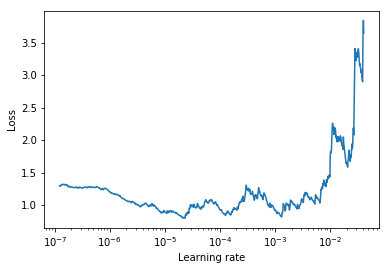

In [135]:
#lr_finder(model,train_loader)

In [4]:
from tensorboardX import SummaryWriter
writer = SummaryWriter()
device = 'cuda'
cls_criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10
onecyc = OneCycle(len(train_loader)*num_epochs,1e-3)

NameError: name 'nn' is not defined

In [192]:
from torch.autograd import Variable
for epoch in range(num_epochs):
    print('')
    print(f"--- Epoch {epoch} ---")
    phase1 = dataloaders.keys()
    acc_all = list()
    loss_all = list()
    for phase in phase1:
        print('')
        print(f"--- Phase {phase} ---")
        epoch_metrics = {"loss": [], "acc": []}
        if phase == ' train':
            model.train()
        else:
            model.eval()
        for batch_i, (X, y) in enumerate(dataloaders[phase]):
            image_sequences = Variable(X.to(device), requires_grad=True)
            labels = Variable(y.to(device), requires_grad=False)
            optimizer.zero_grad()
            #model.lstm.reset_hidden_state()
            predictions = model(image_sequences)
            loss = cls_criterion(predictions, labels)
            acc = 100 * (predictions.detach().argmax(1) == labels).cpu().numpy().mean()
            loss.backward()
            optimizer.step()
            epoch_metrics["loss"].append(loss.item())
            epoch_metrics["acc"].append(acc)
            if(phase=='train'):
                lr,_ = onecyc.calc()
                update_lr(optimizer, lr)
            batches_done = epoch * len(dataloaders[phase]) + batch_i
            batches_left = num_epochs * len(dataloaders[phase]) - batches_done

            sys.stdout.write(
                    "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f), Acc: %.2f%% (%.2f%%)]"
                    % (
                        epoch,
                        num_epochs,
                        batch_i,
                        len(dataloaders[phase]),
                        loss.item(),
                        np.mean(epoch_metrics["loss"]),
                        acc,
                        np.mean(epoch_metrics["acc"]),
                    )
                )

                # Empty cache
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        if(phase=='train'):
            writer.add_scalar('data/acc',np.mean(epoch_metrics["acc"]) , epoch)
            writer.add_scalar('data/loss',np.mean(epoch_metrics["loss"]) , epoch)
            acc_all.append(np.mean(epoch_metrics["acc"]))
            loss_all.append(np.mean(epoch_metrics["loss"]))
        if(phase=='val'):
            writer.add_scalar('data/valacc',np.mean(epoch_metrics["acc"]) , epoch)
            writer.add_scalar('data/valloss',np.mean(epoch_metrics["loss"]) , epoch)
        print('')
        print('{} , acc: {}'.format(phase,np.mean(epoch_metrics["acc"])))


--- Epoch 0 ---

--- Phase train ---
[Epoch 0/10] [Batch 1339/1340] [Loss: 0.748327 (0.893573), Acc: 100.00% (47.61%)]train , acc:

--- Phase val ---
[Epoch 0/10] [Batch 357/358] [Loss: 0.662816 (0.993173), Acc: 100.00% (56.98%)]val , acc:

--- Epoch 1 ---

--- Phase train ---
[Epoch 1/10] [Batch 1339/1340] [Loss: 0.741128 (0.874483), Acc: 0.00% (47.46%)]train , acc:

--- Phase val ---
[Epoch 1/10] [Batch 357/358] [Loss: 0.577067 (0.990671), Acc: 100.00% (56.98%)]val , acc:

--- Epoch 2 ---

--- Phase train ---
[Epoch 2/10] [Batch 1339/1340] [Loss: 0.819749 (0.875605), Acc: 0.00% (48.84%)]train , acc:

--- Phase val ---
[Epoch 2/10] [Batch 357/358] [Loss: 0.522056 (0.995159), Acc: 100.00% (56.35%)]val , acc:

--- Epoch 3 ---

--- Phase train ---
[Epoch 3/10] [Batch 1339/1340] [Loss: 0.603037 (0.885863), Acc: 100.00% (48.00%)]train , acc:

--- Phase val ---
[Epoch 3/10] [Batch 357/358] [Loss: 2.376471 (0.993659), Acc: 0.00% (56.77%)]val , acc:

--- Epoch 4 ---

--- Phase train ---
[Epo

In [193]:
torch.save(model.state_dict(),'./t3d_10.h5')

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


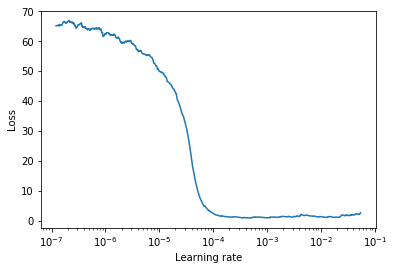

In [194]:
lr_finder(model,train_loader)

In [198]:
model.load_state_dict(torch.load('./t3d_10.h5'))
cls_criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)
num_epochs = 5
onecyc = OneCycle(len(train_loader)*num_epochs,5e-2)

In [ ]:
from torch.autograd import Variable
for epoch in range(10,15):
    print('')
    print(f"--- Epoch {epoch} ---")
    phase1 = dataloaders.keys()
    acc_all = list()
    loss_all = list()
    for phase in phase1:
        print('')
        print(f"--- Phase {phase} ---")
        epoch_metrics = {"loss": [], "acc": []}
        if phase == ' train':
            model.train()
        else:
            model.eval()
        for batch_i, (X, y) in enumerate(dataloaders[phase]):
            image_sequences = Variable(X.to(device), requires_grad=True)
            labels = Variable(y.to(device), requires_grad=False)
            optimizer.zero_grad()
            #model.lstm.reset_hidden_state()
            predictions = model(image_sequences)
            loss = cls_criterion(predictions, labels)
            acc = 100 * (predictions.detach().argmax(1) == labels).cpu().numpy().mean()
            loss.backward()
            optimizer.step()
            epoch_metrics["loss"].append(loss.item())
            epoch_metrics["acc"].append(acc)
            if(phase=='train'):
                lr,_ = onecyc.calc()
                update_lr(optimizer, lr)
            batches_done = epoch * len(dataloaders[phase]) + batch_i
            batches_left = num_epochs * len(dataloaders[phase]) - batches_done

            sys.stdout.write(
                    "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f), Acc: %.2f%% (%.2f%%)]"
                    % (
                        epoch,
                        num_epochs,
                        batch_i,
                        len(dataloaders[phase]),
                        loss.item(),
                        np.mean(epoch_metrics["loss"]),
                        acc,
                        np.mean(epoch_metrics["acc"]),
                    )
                )

                # Empty cache
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        if(phase=='train'):
            writer.add_scalar('data/acc',np.mean(epoch_metrics["acc"]) , epoch)
            writer.add_scalar('data/loss',np.mean(epoch_metrics["loss"]) , epoch)
            acc_all.append(np.mean(epoch_metrics["acc"]))
            loss_all.append(np.mean(epoch_metrics["loss"]))
        if(phase=='val'):
            writer.add_scalar('data/valacc',np.mean(epoch_metrics["acc"]) , epoch)
            writer.add_scalar('data/valloss',np.mean(epoch_metrics["loss"]) , epoch)
        print('')
        print('{} , acc: {}'.format(phase,np.mean(epoch_metrics["acc"])))


--- Epoch 10 ---

--- Phase train ---
[Epoch 10/5] [Batch 241/1340] [Loss: 0.772440 (0.952574), Acc: 50.00% (48.86%)]]

In [ ]:
torch.save(model.state_dict(),'./t3d_15.h5')
lr_finder(model,train_loader)

In [ ]:
model.load_state_dict(torch.load('./t3d_10.h5'))
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,momentum = 0.9)
num_epochs = 5
onecyc = OneCycle(len(train_loader)*num_epochs,0.001)